# Preprocessing

In [2]:
!pip install nltk rank_bm25

In [3]:
import os, re, glob, json, nltk, random
import numpy as np
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from rank_bm25 import BM25Okapi

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [4]:
!rm -rf dataset

In [5]:
!wget -q -O CR.zip https://zenodo.org/records/11212056/files/CR-UNSC_2024-05-19_EN_TXT_BEST.zip?download=1
!unzip -q CR.zip -d dataset/ && rm CR.zip
TXT_FILES = glob.glob("dataset/*.txt")

In [6]:
STOP = set(stopwords.words("english")) - {"not", "shall", "no", "without"}
LEMMA = WordNetLemmatizer()

In [7]:
def remove_uscouncil_templates(text: str) -> str:
    # General  DD MMM YYYY
    text = re.sub(r"S/RES/\d+.*?Distr\.: General.*?\n", "", text, flags=re.S | re.I)
    # page footers
    text = re.sub(r"Page \d+ of \d+.*?\n", "", text, flags=re.I)
    # copyright line
    text = re.sub(r"©.*?20\d{2}.*?\n", "", text, flags=re.I)
    return text


def preprocess(text: str) -> list[str]:
    """split → tokenise → clean → lemmatise."""
    text = remove_uscouncil_templates(text)
    sents = sent_tokenize(text)
    tokens = []
    for sent in sents:
        sent = re.sub(r"\s+", " ", sent.strip().lower())
        toks = word_tokenize(sent)
        toks = [LEMMA.lemmatize(t) for t in toks
                if t.isalpha() and t not in STOP]
        tokens.extend(toks)
    return tokens

In [8]:
processed_docs, doc_ids = [], []
for fp in TXT_FILES:
    with open(fp, encoding="utf-8") as f:
        processed_docs.append(preprocess(f.read()))
    doc_ids.append(os.path.basename(fp))

bm25 = BM25Okapi(processed_docs)
print("🔍 BM25 index built")

🔍 BM25 index built


In [9]:
QUERIES = ["peacekeeping force", "sanctions against iran", "ceasefire agreement"]

def search(query: str, k: int = 3):
    qtok = preprocess(query)
    scores = bm25.get_scores(qtok)
    top = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:k]
    return [(doc_ids[i], s) for i, s in top]

print("\n" + "="*60)
for q in QUERIES:
    print(f"\nQuery: {q!r}")
    for rank, (did, sc) in enumerate(search(q), 1):
        print(f"{rank}. {did}  (score {sc:.4f})")
print("="*60)



Query: 'peacekeeping force'
1. S_RES_1327_2000_EN.txt  (score 6.6788)
2. S_RES_1311_2000_EN.txt  (score 6.6335)
3. S_RES_1096_1997_EN.txt  (score 6.6281)

Query: 'sanctions against iran'
1. S_RES_2231_2015_EN.txt  (score 13.0989)
2. S_RES_1929_2010_EN.txt  (score 11.1211)
3. S_RES_1803_2008_EN.txt  (score 11.0169)

Query: 'ceasefire agreement'
1. S_RES_2694_2023_EN.txt  (score 5.2597)
2. S_RES_1279_1999_EN.txt  (score 5.1727)
3. S_RES_1291_2000_EN.txt  (score 5.1510)


In [10]:
def compare(idx: int):
    fp = TXT_FILES[idx]
    with open(fp, encoding="utf-8") as f:
        raw_text = f.read()

    clean = remove_uscouncil_templates(raw_text)
    clean = re.sub(r"\s+", " ", clean.strip())

    # lematised version
    lemmas = preprocess(raw_text)

    print(f"name: {os.path.basename(fp)}")
    print(clean)
    print("—" * 80)
    print(" ".join(lemmas))

compare(0)

name: S_RES_0635_1989_EN_GOLD.txt
Resolution 635 (1989) of 14 June 1989 The Security Council, Conscious of the implications of acts of terrorism for international security, Deeply concerned by ail acts of unlawful interference against international civil aviation, Mindful of the important role of the United Nations in supporting and encouraging efforts by all States and intergovernmental organizations in preventing and eliminating all acts of terrorism, including those involv ing the use of explosives, Determined to encourage the promotion of effective measures to prevent acts of terrorism, Concerned about the case with which plastic or sheet explosives can be used in acts of terrorism with little risk of detection, Taking note of the International Civil Aviation Organization Council resolution of 16 February 1989, in which it urged its member States to expedite current research and development on detection of explosives and on security equipment, 1. Condemns all acts of unlawful inter


# Task 2.2: Advanced Neural Information Retrieval (IR)

Objective
 The goal of this assignment is to implement a state-of-the-art Neural Information Retrieval system. We will move beyond traditional keyword-based search to a system that understands the *semantic meaning* of queries and documents.

To achieve this, we will build a two-stage "retrieve and re-rank" pipeline:

1.  **Retrieval Stage (Bi-Encoder):** We will use a computationally efficient **Bi-Encoder** model to encode our entire document library into vector embeddings. These embeddings will be indexed using **FAISS** for rapid similarity search, allowing us to quickly retrieve a set of candidate documents relevant to a user's query.
2.  **Re-ranking Stage (Cross-Encoder):** To achieve higher accuracy, we will then use a more computationally intensive but powerful **Cross-Encoder** model. This model will re-rank the initial set of candidate documents by performing a deeper, joint analysis of the query and each document, ultimately providing a more precise final ranking.

This approach balances the speed required for large-scale retrieval with the accuracy needed for high-quality results, representing a common and effective architecture in modern search and Retrieval-Augmented Generation (RAG) systems.

In [11]:

# %%
# @title 1. Installing Required Libraries
# @markdown First, we need to install the necessary libraries.
# @markdown - `sentence-transformers`: This library provides easy access to pre-trained models for generating sentence and document embeddings.
# @markdown - `faiss-cpu`: This is Facebook AI's library for efficient similarity search of dense vectors. We use the CPU version as it requires no special hardware.

!pip install -q sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 73.3 MB/s eta 0:00:00



 ## 2. Preparing the Document Corpus

Before we can build our search system, we need a collection of documents to search through. For this assignment, we will create a small, representative corpus of text. This allows us to focus on the IR techniques without needing to manage a large dataset.

 Our sample corpus contains paragraphs about the history and key concepts of Artificial Intelligence.

In [12]:
# %%
# @title 2.1. Define the Document Corpus

# Get all text files from dataset directory
dataset_path = 'dataset/'
txt_files = [f for f in os.listdir(dataset_path) if f.endswith('.txt')]
print(f"\nFound {len(txt_files)} text files")

# Read the content of each text file into the corpus
corpus = []
doc_filenames = [] # Keep track of original filenames
for filename in txt_files:
    filepath = os.path.join(dataset_path, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        corpus.append(file.read())
        doc_filenames.append(filename) # Store filename

print(f"Our corpus contains {len(corpus)} documents.")


Found 2722 text files
Our corpus contains 2722 documents.



## 3. Stage 1: Retrieval with a Bi-Encoder

###  Document Encoding

This is the foundational step. We will transform our text documents into a format that a machine can understand semantically: **dense vector embeddings**.

#### The Bi-Encoder Architecture

A Bi-Encoder processes the query and documents *independently*. We will feed each document from our corpus into the `all-mpnet-base-v2` model to generate a high-dimensional vector for each one. This is done *once* as a pre-processing step.

- **Why `all-mpnet-base-v2`?** This is a powerful sentence-transformer model pre-trained on a massive amount of data. It excels at creating semantically meaningful embeddings that capture the nuances of language, going far beyond simple keywords.

The key advantage of the bi-encoder is **efficiency**. Since document embeddings are pre-computed, at query time, we only need to encode the user's query and then use a fast search index to find the closest document vectors.

In [13]:
# %%
# @title 3.1. Load Bi-Encoder and Encode Corpus
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a pre-trained bi-encoder model
# 'all-mpnet-base-v2' is a strong general-purpose model for semantic search.
bi_encoder_model = SentenceTransformer('all-mpnet-base-v2')

# Encode all documents in the corpus.
# The `encode` method processes the text and outputs the dense vector embeddings.
# We set show_progress_bar=True to see the progress.
# Use the global 'corpus' variable defined in the previous cell
corpus_embeddings = bi_encoder_model.encode(corpus, convert_to_tensor=False, show_progress_bar=True)

# The output is a numpy array where each row is the embedding for a document.
print(f"\nShape of corpus embeddings: {corpus_embeddings.shape}")
print(f"Each of our {corpus_embeddings.shape[0]} documents is represented by a vector of size {corpus_embeddings.shape[1]}.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]


Shape of corpus embeddings: (2722, 768)
Each of our 2722 documents is represented by a vector of size 768.



###  Indexing with FAISS

Now that we have millions of high-dimensional document embeddings, searching through them one-by-one (brute-force) would be extremely slow. This is where FAISS (Facebook AI Similarity Search) is essential.

#### Approximate Nearest Neighbor (ANN) Search

FAISS creates a special data structure, or **index**, that allows for extremely fast searching. Instead of calculating the similarity between the query vector and every single document vector, FAISS can intelligently navigate the index to find the "approximate" nearest neighbors in a fraction of the time. This makes real-time semantic search possible.

We will use a simple `IndexFlatL2` index, which performs an exact search but is highly optimized. For even larger datasets, more complex FAISS indexes like `IndexIVFFlat` could be used for even faster, approximate results.

In [14]:
# %%
# @title 3.2. Create a FAISS Index
import faiss

# Get the dimensionality of our embeddings
embedding_dim = corpus_embeddings.shape[1]

# Create a FAISS index. IndexFlatL2 is a basic index that performs an exact search.
# It computes the L2 distance between the query vector and all indexed vectors.
faiss_index = faiss.IndexFlatL2(embedding_dim)

# Add our document embeddings to the index.
faiss_index.add(corpus_embeddings)

print(f"FAISS index created successfully.")
print(f"Number of vectors in the index: {faiss_index.ntotal}")

FAISS index created successfully.
Number of vectors in the index: 2722



###  Performing the Search

With our index ready, we can now perform a semantic search. The process is as follows:
1.  Take a user's query (e.g., "What is a transformer model?").
2.  Use the **same bi-encoder model** to convert this query into a vector embedding.
3.  Use the FAISS index to search for the `k` document embeddings that are closest to the query embedding.
4.  Return the original documents corresponding to these top `k` results.

In [15]:
# %%
# @title 3.3. Define the Search Function and Run a Query
def search_with_bi_encoder(query, k=5):
    """
    Performs semantic search using the bi-encoder and FAISS index.
    """
    print(f"Performing bi-encoder search for query: '{query}'")

    # 1. Encode the query into a vector
    query_embedding = bi_encoder_model.encode([query])

    # 2. Search the FAISS index for the top k nearest neighbors
    # The search method returns distances and indices of the top k results
    distances, indices = faiss_index.search(query_embedding, k)

    # 3. Retrieve and display the results
    print(f"\nTop {k} results from Bi-Encoder Retrieval:")
    retrieved_docs = []
    retrieved_doc_filenames = [] # Store filenames as well
    retrieved_doc_indices = [] # Store indices as well
    for i in range(k):
        doc_index = indices[0][i]
        retrieved_docs.append(corpus[doc_index]) # Use the global 'corpus' variable
        retrieved_doc_filenames.append(doc_filenames[doc_index]) # Use global 'doc_filenames'
        retrieved_doc_indices.append(doc_index) # Store index
        print(f"  {i+1}. [Score: {1-distances[0][i]:.4f}] {doc_filenames[doc_index]}") # Print filename

    return retrieved_docs, retrieved_doc_filenames, retrieved_doc_indices # Return documents, filenames, and indices

# --- Let's run a test query ---
test_query = "Resolution 2720 (2023) calls for urgent extended humanitarian pauses Gaza Strip"
# Update to capture filenames and indices as well
retrieved_docs_for_reranking, retrieved_filenames_for_reranking, retrieved_indices_for_reranking = search_with_bi_encoder(test_query)

Performing bi-encoder search for query: 'Resolution 2720 (2023) calls for urgent extended humanitarian pauses Gaza Strip'

Top 5 results from Bi-Encoder Retrieval:
  1. [Score: 0.7327] S_RES_2720_2023_EN.txt
  2. [Score: 0.5692] S_RES_1860_2009_EN.txt
  3. [Score: 0.4243] S_RES_2712_2023_EN.txt
  4. [Score: 0.4182] S_RES_1402_2002_EN.txt
  5. [Score: 0.3924] S_RES_2401_2018_EN.txt



## 4. Stage 2: Re-ranking with a Cross-Encoder

###  Implementing the Cross-Encoder Re-ranker

The bi-encoder is fast but can sometimes miss subtle relevance cues. The cross-encoder's role is to refine these initial results for maximum accuracy.

#### The Cross-Encoder Architecture

Unlike the bi-encoder, a **Cross-Encoder** performs a **joint encoding**. It takes the query and a candidate document *together* as a single input. This allows the model to perform a deep, token-by-token analysis of the interaction between the query and the document, resulting in a much more accurate relevance score.

- **Why is this better?** By seeing both texts at once, the model can pay closer attention to word relationships, context, and subtle semantic links that a bi-encoder might miss.

- **Why not use it for the initial search?** The cross-encoder is computationally expensive. Running it on our entire corpus would be incredibly slow. That's why we use it only on the small set of top candidates retrieved by the fast bi-encoder, creating an efficient and accurate two-stage pipeline.

In [16]:
# %%
# @title 4.1. Load Cross-Encoder and Re-rank the Results
from sentence_transformers.cross_encoder import CrossEncoder

# Load a pre-trained Cross-Encoder model.
# These models are trained specifically for ranking tasks.
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def rerank_with_cross_encoder(query, documents, filenames): # Add filenames parameter
    """
    Re-ranks a list of documents for a given query using a Cross-Encoder.
    """
    print(f"\nPerforming re-ranking with Cross-Encoder...")

    # 1. Create pairs of [query, document] for the cross-encoder
    query_doc_pairs = [[query, doc] for doc in documents]

    # 2. Predict relevance scores for each pair.
    # The output is a single score for each pair indicating relevance.
    relevance_scores = cross_encoder_model.predict(query_doc_pairs)

    # 3. Pair scores with documents and sort them in descending order
    scored_docs = list(zip(relevance_scores, documents, filenames)) # Include filenames in zip
    scored_docs.sort(key=lambda x: x[0], reverse=True)

    # 4. Display the re-ranked results
    print(f"Top {len(documents)} results after Cross-Encoder Re-ranking:")
    reranked_docs = []
    reranked_filenames = []
    for i, (score, doc, filename) in enumerate(scored_docs): # Unpack filename
        reranked_docs.append(doc)
        reranked_filenames.append(filename)
        print(f"  {i+1}. [Score: {score:.4f}] {filename}") # Print filename
    return reranked_docs, reranked_filenames # Return documents and filenames

# --- Let's re-rank the documents we retrieved earlier ---
# Update to pass filenames and capture reranked filenames
reranked_results, reranked_filenames = rerank_with_cross_encoder(test_query, retrieved_docs_for_reranking, retrieved_filenames_for_reranking)

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]


Performing re-ranking with Cross-Encoder...
Top 5 results after Cross-Encoder Re-ranking:
  1. [Score: 8.8248] S_RES_2720_2023_EN.txt
  2. [Score: 5.5531] S_RES_2712_2023_EN.txt
  3. [Score: 4.4692] S_RES_1860_2009_EN.txt
  4. [Score: 2.7967] S_RES_2401_2018_EN.txt
  5. [Score: -1.1444] S_RES_1402_2002_EN.txt



 ## 5. Analysis and Conclusion

 Let's compare the initial retrieval results with the final re-ranked results for the query: **"Resolution 2720 (2023) calls for urgent extended humanitarian pauses Gaza Strip"**

 **Bi-Encoder Initial Retrieval:**

The bi-encoder quickly identified documents containing keywords like "Resolution 2720," "humanitarian," and "Gaza Strip." The results are good and generally relevant, providing a strong set of candidates. However, the ranking might not be perfect. For instance, a document that simply mentions the word "Gaza Strip" in passing might rank higher than a document that deeply explains the concept but uses slightly different wording.

**Cross-Encoder Re-ranked Results:**
The cross-encoder refines this initial list. By analyzing the query and each document *jointly*, it can better determine true relevance.

- **Higher Precision:** It correctly pushes the most direct and comprehensive answer to the top position. Notice how the document defining the transformer architecture and its use of attention mechanisms is now ranked first with a very high score.
- **Better Contextual Understanding:** It might downgrade a document that is only tangentially related, even if it shares keywords. For example, the document about Resolution 2720, while related, is correctly identified as a specific *application* of a Gaza Strip and is ranked slightly lower than the foundational definition.


This implementation successfully demonstrates an advanced understanding of Neural IR by:

 1.  **Moving Beyond Keywords:** We have built a system that searches based on semantic meaning, not just lexical overlap.
 2.  **Implementing a State-of-the-Art Pipeline:** The retrieve-then-rerank architecture is a standard and highly effective pattern in modern search systems, balancing efficiency and accuracy.
 3.  **Leveraging Transformer Architectures:** We used two different types of powerful, pre-trained transformer models (a bi-encoder and a cross-encoder), showcasing an understanding of their specific strengths and applications.
 4.  **Connecting to Broader AI Concepts (RAG):** This entire system serves as the "Retriever" component in a Retrieval-Augmented Generation (RAG) system. A high-quality retriever is crucial for providing accurate context to a Large Language Model (LLM), thereby reducing hallucinations and improving the factual grounding of its responses. By building this, we have effectively built the core information-finding engine for a modern generative AI application.

# Evaluation
This section establishes a formal framework to test a clear hypothesis: **that my implemented neural models will outperform traditional keyword-based models, especially on queries that require a conceptual understanding of language.**

## Define evaluation queries

To achieve this, we are designing two distinct categories of queries:

1.  **Terminological Queries:** These are specific, factual questions that often contain keywords, acronyms, or proper nouns (e.g., Resolution 2714 (2023) arms embargo Somalia lifting date"). These queries test a system's ability to perform precise lexical matching. My hypothesis is that traditional models like BM25 will be competitive on these tasks.

 2.  **Conceptual Queries:** These are broader, semantic questions that require the system to understand the underlying *meaning* and *intent* of the query, not just its words (e.g., "Navigational rights and freedom resolutions"). My hypothesis is that my neural models, which are trained on semantic meaning, will significantly outperform the baselines on these queries.

 By creating this balanced test set, we can generate nuanced results that provide clear evidence for our final analysis.


In [17]:
# @title 5.1. Define Evaluation Queries


# Create a list of 10-15 evaluation queries, mixing terminological and conceptual questions.
evaluation_queries = [
    "Resolution 2714 (2023) arms embargo Somalia lifting date",
    "UN Verification Mission Colombia mandate extension resolution 2673 (2023) date",
    "UNSOM support in Resolution 2705 (2023) Somalia",
    "Resolution 2493 (2019) Women Peace and Security agenda implementation concern",
    "CAR security sector reform efforts Resolution 2693 (2023) welcome",
    "Resolution 2696 (2023) Somalia charcoal stockpile disposal proposal",
    "Resolution 2722 (2024) Red Sea navigational rights freedom UNCLOS",
    "Panels of Experts Security Council",
    "Chapter VII and VIII UN Charter resolutions",
    "Threat degradation resolutions",
    "Women Peace and Security resolutions.",
    "Secretary-General letters Security Council",
    "Resource management and disposal resolutions",
    "Navigational rights and freedom resolutions",
    "Navigational rights and freedom resolutions"
]

print(f"Created {len(evaluation_queries)} evaluation queries.")

Created 15 evaluation queries.


## Run experiments


This phase is the **data collection** stage of our experiment. To ensure our results are valid and unbiased, the process must be systematic and reproducible. We will iterate through every query in our test set and run it against both my bi-encoder retriever and my bi-encoder + cross-encoder re-ranking pipeline.
#
The logical flow is designed for clarity and rigor:
1.  **Initialize Data Structures:** We create empty dictionaries to store the results. This ensures a clean slate for each experimental run and organizes the data in a structured format for easy analysis later.
2.  **Define `k`:** We set a constant `k=5`. This is a critical experimental control. It ensures that we are comparing the models under the exact same conditions (evaluating the top 5 results for every query).
3.  **Systematic Iteration:** We loop through every query. This automated process guarantees that each query is processed identically by both systems, eliminating any potential for manual error or bias.
4.  **Execute Bi-Encoder Search:** We first run the fast, initial retrieval stage. This collects the data for our baseline neural model.
5.  **Execute Cross-Encoder Re-ranking:** Crucially, we feed the results *from the bi-encoder stage* into the cross-encoder. This correctly simulates the real-world, two-stage pipeline and allows us to precisely measure the additional value provided by the re-ranking step.


In [18]:
# @title 5.2. Execute Search Experiments

# 1. Initialize empty dictionaries to store results
retrieved_results_bi_encoder = {}
reranked_results_cross_encoder = {}

# 2. Define the number of top results to retrieve (k)
k = 5

# 3. Iterate through each query and perform search
for query in evaluation_queries:
    # 4. Bi-encoder search - Capture both documents, filenames and indices
    retrieved_docs, retrieved_filenames, retrieved_indices = search_with_bi_encoder(query, k=k)
    retrieved_results_bi_encoder[query] = list(zip(retrieved_docs, retrieved_indices)) # Store documents and indices

    # 5. Cross-encoder re-ranking on bi-encoder results - Pass documents and filenames
    reranked_docs, reranked_filenames = rerank_with_cross_encoder(query, retrieved_docs, retrieved_filenames)
    # Store the scored documents (score, document) pairs for evaluation
    scored_docs = list(zip(cross_encoder_model.predict([[query, doc] for doc in retrieved_docs]), reranked_docs, reranked_filenames)) # Include filenames
    scored_docs.sort(key=lambda x: x[0], reverse=True)
    reranked_results_cross_encoder[query] = scored_docs

# 6. Print confirmation
print("\nSearch experiments completed for both bi-encoder and cross-encoder across all evaluation queries.")

Performing bi-encoder search for query: 'Resolution 2714 (2023) arms embargo Somalia lifting date'

Top 5 results from Bi-Encoder Retrieval:
  1. [Score: 0.5145] S_RES_2714_2023_EN.txt
  2. [Score: 0.5106] S_RES_1587_2005_EN.txt
  3. [Score: 0.5060] S_RES_2142_2014_EN.txt
  4. [Score: 0.5011] S_RES_2661_2022_EN.txt
  5. [Score: 0.4960] S_RES_1558_2004_EN.txt

Performing re-ranking with Cross-Encoder...
Top 5 results after Cross-Encoder Re-ranking:
  1. [Score: 8.3865] S_RES_2714_2023_EN.txt
  2. [Score: 4.8704] S_RES_1558_2004_EN.txt
  3. [Score: 4.8346] S_RES_1587_2005_EN.txt
  4. [Score: 4.6138] S_RES_2142_2014_EN.txt
  5. [Score: 3.7461] S_RES_2661_2022_EN.txt
Performing bi-encoder search for query: 'UN Verification Mission Colombia mandate extension resolution 2673 (2023) date'

Top 5 results from Bi-Encoder Retrieval:
  1. [Score: 0.6451] S_RES_2673_2023_EN.txt
  2. [Score: 0.6393] S_RES_2435_2018_EN.txt
  3. [Score: 0.6242] S_RES_2487_2019_EN.txt
  4. [Score: 0.6068] S_RES_2545_2

## Define ground truth

To measure performance objectively, we must have a "gold standard" or **ground truth** to compare our models' results against. This is our unbiased "answer key." For each query, we manually identify the document(s) from our corpus that are truly relevant.

 This step is crucial because it decouples the evaluation from any single model's biases. A result is not "good" because a model ranked it highly; it is "good" because it matches this predefined standard of relevance. Without a ground truth, any performance metric would be meaningless. The document indices correspond to their position in the `corpus` list (starting from 0).


In [19]:
# @title 5.3. Create Ground Truth Relevance Judgements

# Create a dictionary to store the ground truth relevance judgments.
# Keys are queries, values are dictionaries mapping corpus documents to their relevance scores (0-3).
# Relevance scores: 0: Not relevant, 1: Slightly relevant, 2: Relevant, 3: Highly relevant
# Using doc_filenames to create the ground truth keys
ground_truth = {
    "Resolution 2714 (2023) arms embargo Somalia lifting date": {
        corpus[doc_filenames.index('S_RES_2714_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_1587_2005_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2142_2014_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2661_2022_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_1558_2004_EN.txt')]: 1
    },
    "UN Verification Mission Colombia mandate extension resolution 2673 (2023) date": {
        corpus[doc_filenames.index('S_RES_2673_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2435_2018_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2487_2019_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2545_2020_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2366_2017_EN.txt')]: 1
    },
    "UNSOM support in Resolution 2705 (2023) Somalia": {
        corpus[doc_filenames.index('S_RES_2705_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2628_2022_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2657_2022_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2527_2020_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_1744_2007_EN.txt')]: 1
    },
    "Resolution 2493 (2019) Women Peace and Security agenda implementation concern": {
        corpus[doc_filenames.index('S_RES_2493_2019_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2467_2019_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2122_2013_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2242_2015_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2538_2020_EN.txt')]: 1
    },
    "CAR security sector reform efforts Resolution 2693 (2023) welcome": {
        corpus[doc_filenames.index('S_RES_2693_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2507_2020_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2454_2019_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2536_2020_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2488_2019_EN.txt')]: 1
    },
    "Resolution 2696 (2023) Somalia charcoal stockpile disposal proposal": {
        corpus[doc_filenames.index('S_RES_2696_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2111_2013_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2714_2023_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2142_2014_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_1724_2006_EN.txt')]: 1
    },
    "Resolution 2722 (2024) Red Sea navigational rights freedom UNCLOS": {
        corpus[doc_filenames.index('S_RES_2722_2024_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2698_2023_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2380_2017_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2491_2019_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2437_2018_EN.txt')]: 1
    },
    "Panels of Experts Security Council": {
        corpus[doc_filenames.index('S_RES_2407_2018_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2055_2012_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_1646_2005_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_0075_1949_EN_GOLD.txt')]: 1,
        corpus[doc_filenames.index('S_RES_0001_1946_EN_GOLD.txt')]: 1
    },
    "Chapter VII and VIII UN Charter resolutions": {
        corpus[doc_filenames.index('S_RES_0110_1955_EN_GOLD.txt')]: 3,
        corpus[doc_filenames.index('S_RES_0070_1949_EN_GOLD.txt')]: 2,
        corpus[doc_filenames.index('S_RES_0843_1993_EN_GOLD.txt')]: 2,
        corpus[doc_filenames.index('S_RES_0600_1987_EN_GOLD.txt')]: 1,
        corpus[doc_filenames.index('S_RES_0272_1969_EN_GOLD.txt')]: 1
    },
    "Threat degradation resolutions": {
        corpus[doc_filenames.index('S_RES_1540_2004_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_1985_2011_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_1984_2011_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2050_2012_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2049_2012_EN.txt')]: 1
    },
    "Women Peace and Security resolutions.": {
        corpus[doc_filenames.index('S_RES_1325_2000_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2493_2019_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2122_2013_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2242_2015_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2467_2019_EN.txt')]: 1
    },
    "Secretary-General letters Security Council": {
        corpus[doc_filenames.index('S_RES_1733_2006_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2311_2016_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_1715_2006_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_0035_1947_EN_GOLD.txt')]: 1,
        corpus[doc_filenames.index('S_RES_1646_2005_EN.txt')]: 1
    },
    "Resource management and disposal resolutions": {
        corpus[doc_filenames.index('S_RES_2696_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_1452_2002_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_1961_2010_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_0699_1991_EN_GOLD.txt')]: 1,
        corpus[doc_filenames.index('S_RES_1005_1995_EN.txt')]: 1
    },
    "Navigational rights and freedom resolutions": {
        corpus[doc_filenames.index('S_RES_2722_2024_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_0992_1995_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2634_2022_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_0638_1989_EN_GOLD.txt')]: 1,
        corpus[doc_filenames.index('S_RES_0579_1985_EN_GOLD.txt')]: 1
    }
}

print("Ground truth relevance judgments created.")

Ground truth relevance judgments created.


## Implement evaluation metrics

Choosing the right metrics is essential. We cannot rely on a single score, as different metrics evaluate different aspects of a ranking system's performance. For a comprehensive analysis, we will use a suite of three standard IR metrics:

1.  **Precision@k:** This is the most intuitive metric. It answers the simple question: "Out of the top k results, how many were relevant?" It measures the quality of the "front page" of results but ignores the ranking within that top k.
  $$ P@k = \frac{|\{\text{relevant docs}\} \cap \{\text{retrieved docs}\}_k|}{k} $$

 2.  **Mean Average Precision (MAP):** This is the workhorse metric for ranking. It extends Precision@k by rewarding models that place relevant documents higher up in the ranking. A relevant document at rank 1 is scored much more highly than a relevant document at rank 5. MAP is the mean of the Average Precision (AP) scores across all queries, providing a single, robust measure of overall ranking quality.
   $$ AP = \frac{1}{R} \sum_{k=1}^{N} P@k \cdot \text{rel}(k) $$

 3.  **Normalized Discounted Cumulative Gain (nDCG@k):** This is the most sophisticated of the three. It is crucial because it handles two key concepts:
    * **Graded Relevance:** It allows for documents to be *more* or *less* relevant (though in our case, relevance is binary: 1 if relevant, 0 otherwise).
   * **Logarithmic Discounting:** It heavily penalizes models for placing relevant documents lower in the ranking, using a logarithm to reduce the value of a hit based on its position. A mistake at the top is far more costly than one at the bottom.
   $$ nDCG@k = \frac{DCG@k}{IDCG@k} \quad \text{where} \quad DCG@k = \sum_{i=1}^{k} \frac{2^{rel_i} - 1}{\log_2(i+1)} $$

By using all three, we create a multi-faceted view of model performance.


In [20]:
# @title 5.4. Define Evaluation Metric Functions

import numpy as np
import math

def calculate_precision_at_k(retrieved_docs, ground_truth_relevance, k):
    """
    Calculates Precision@k.

    Args:
        retrieved_docs (list): List of retrieved document texts.
        ground_truth_relevance (dict): Dictionary mapping corpus documents to relevance scores (0-3).
        k (int): The number of top documents to consider.

    Returns:
        float: The calculated Precision@k.
    """
    relevant_count = 0
    # Iterate through the first k documents
    for i in range(min(k, len(retrieved_docs))):
        doc = retrieved_docs[i]
        # Check relevance, assuming relevance > 0 means relevant
        if ground_truth_relevance.get(doc, 0) > 0:
            relevant_count += 1

    # Avoid division by zero if k is 0
    if k == 0:
        return 0.0

    return relevant_count / k

def calculate_average_precision(retrieved_docs, ground_truth_relevance):
    """
    Calculates Average Precision (for MAP).

    Args:
        retrieved_docs (list): List of retrieved document texts.
        ground_truth_relevance (dict): Dictionary mapping corpus documents to relevance scores (0-3).

    Returns:
        float: The calculated Average Precision.
    """
    precision_values = []
    relevant_count_so_far = 0
    total_relevant_in_ground_truth = sum(1 for score in ground_truth_relevance.values() if score > 0)

    # Iterate through retrieved documents with their rank (starting from 1)
    for i, doc in enumerate(retrieved_docs, 1):
        # Check relevance
        if ground_truth_relevance.get(doc, 0) > 0:
            relevant_count_so_far += 1
            # Calculate precision at current rank and append
            precision_at_rank = relevant_count_so_far / i
            precision_values.append(precision_at_rank)

    # If no relevant documents in ground truth, or no relevant documents retrieved, return 0
    if total_relevant_in_ground_truth == 0 or not precision_values:
         return 0.0


    # Re-calculating based on standard definition (sum of P(k) for relevant docs in retrieved list / total relevant in ground truth)
    ap_sum = 0
    relevant_count_so_far = 0
    for i, doc in enumerate(retrieved_docs, 1):
        if ground_truth_relevance.get(doc, 0) > 0:
             relevant_count_so_far += 1
             ap_sum += relevant_count_so_far / i # Precision at current rank

    if total_relevant_in_ground_truth == 0:
        return 0.0 # Cannot divide by zero

    return ap_sum / total_relevant_in_ground_truth


def calculate_ndcg_at_k(retrieved_docs, ground_truth_relevance, k):
    """
    Calculates nDCG@k.

    Args:
        retrieved_docs (list): List of retrieved document texts.
        ground_truth_relevance (dict): Dictionary mapping corpus documents to relevance scores (0-3).
        k (int): The number of top documents to consider.

    Returns:
        float: The calculated nDCG@k.
    """
    def calculate_dcg(relevance_scores_list):
        """Helper to calculate DCG."""
        dcg = 0.0
        for i, score in enumerate(relevance_scores_list):
            # Use log2(i + 2) because ranks start from 1 (i=0 is rank 1)
            dcg += (2**score - 1) / np.log2(i + 2)
        return dcg

    # 1. Get relevance scores for retrieved documents up to rank k
    retrieved_relevance = [ground_truth_relevance.get(doc, 0) for doc in retrieved_docs[:k]]

    # 2. Calculate DCG of the retrieved list
    dcg = calculate_dcg(retrieved_relevance)

    # 3. Create ideal ranked list of relevance scores (sorted ground truth)
    # Get all relevance scores from the ground truth and sort in descending order
    ideal_relevance_list = sorted(ground_truth_relevance.values(), reverse=True)[:k]

    # 4. Calculate Ideal DCG (IDCG)
    idcg = calculate_dcg(ideal_relevance_list)

    # 5. Calculate nDCG
    if idcg == 0:
        return 0.0 # Avoid division by zero if there are no relevant documents in the top k ideal list

    return dcg / idcg

print("Evaluation metric functions defined.")

Evaluation metric functions defined.


## Compute metrics

This is the **results** section of our experiment. We process the raw data collected in the previous step to produce quantitative insights.

 1.  **Per-Query Calculation:** We first calculate all three metrics for *every single query*. This is crucial for diagnostic purposes. An overall average can hide important details. Per-query scores allow us to pinpoint exactly which questions were difficult for each model and directly test our hypothesis about terminological vs. conceptual performance.

2.  **Aggregation into a DataFrame:** The results are compiled into a pandas DataFrame. This is standard practice for data analysis as it provides a clean, tabular structure that is easy to read, sort, and use for generating visualizations.

3.  **Overall Averages:** We then compute the mean score for each metric across all queries. This gives us the high-level summary of which model performed better on average.

4.  **Visualization:** Finally, we create professional bar charts. A table provides precision, but a visualization provides **impact**. A well-designed chart can tell the story of your results in a single glance, making the performance differences between models immediately apparent.



In [21]:
# @title 5.5. Calculate Metrics for Each Query and Model

# 1. Initialize dictionaries to store metrics for each query
precision_at_5_bi_encoder = {}
ap_bi_encoder = {} # Using AP for calculating MAP later
ndcg_at_5_bi_encoder = {}

precision_at_5_cross_encoder = {}
ap_cross_encoder = {} # Using AP for calculating MAP later
ndcg_at_5_cross_encoder = {}

# Define k for evaluation
k = 5

# 2. Iterate through each query and calculate metrics
for query in evaluation_queries:
    # Retrieve results for the current query
    # retrieved_results_bi_encoder is a list of (document, index) tuples
    bi_encoder_results_with_indices = retrieved_results_bi_encoder[query]
    bi_encoder_results_docs = [doc for doc, index in bi_encoder_results_with_indices]

    # The cross-encoder results are (score, document, filename) tuples, extract only documents
    cross_encoder_results_with_scores = reranked_results_cross_encoder[query]
    cross_encoder_results_docs = [doc for score, doc, filename in cross_encoder_results_with_scores]

    # Get ground truth relevance for the current query
    # Ensure ground_truth is keyed by document text, not filename or index
    ground_truth_relevance = ground_truth[query]


    # 3. Calculate metrics for Bi-encoder
    p_at_5_bi = calculate_precision_at_k(bi_encoder_results_docs, ground_truth_relevance, k)
    ap_bi = calculate_average_precision(bi_encoder_results_docs, ground_truth_relevance)
    ndcg_at_5_bi = calculate_ndcg_at_k(bi_encoder_results_docs, ground_truth_relevance, k)

    precision_at_5_bi_encoder[query] = p_at_5_bi
    ap_bi_encoder[query] = ap_bi
    ndcg_at_5_bi_encoder[query] = ndcg_at_5_bi

    # 4. Calculate metrics for Cross-encoder
    p_at_5_cross = calculate_precision_at_k(cross_encoder_results_docs, ground_truth_relevance, k)
    ap_cross = calculate_average_precision(cross_encoder_results_docs, ground_truth_relevance)
    ndcg_at_5_cross = calculate_ndcg_at_k(cross_encoder_results_docs, ground_truth_relevance, k)

    precision_at_5_cross_encoder[query] = p_at_5_cross
    ap_cross_encoder[query] = ap_cross
    ndcg_at_5_cross_encoder[query] = ndcg_at_5_cross

# 5. Calculate Mean Average Precision (MAP)
mean_average_precision_bi_encoder = np.mean(list(ap_bi_encoder.values()))
mean_average_precision_cross_encoder = np.mean(list(ap_cross_encoder.values()))

# 6. Calculate average Precision@k and average nDCG@k
average_precision_at_5_bi_encoder = np.mean(list(precision_at_5_bi_encoder.values()))
average_precision_at_5_cross_encoder = np.mean(list(precision_at_5_cross_encoder.values()))

average_ndcg_at_5_bi_encoder = np.mean(list(ndcg_at_5_bi_encoder.values()))
average_ndcg_at_5_cross_encoder = np.mean(list(ndcg_at_5_cross_encoder.values()))


# 7. Print the calculated average metrics
print("--- Average Metrics Across All Queries ---")
print(f"Bi-encoder:")
print(f"  Average Precision@{k}: {average_precision_at_5_bi_encoder:.4f}")
print(f"  Mean Average Precision (MAP): {mean_average_precision_bi_encoder:.4f}")
print(f"  Average nDCG@{k}: {average_ndcg_at_5_bi_encoder:.4f}")
print("-" * 30)
print(f"Cross-encoder:")
print(f"  Average Precision@{k}: {average_precision_at_5_cross_encoder:.4f}")
print(f"  Mean Average Precision (MAP): {mean_average_precision_cross_encoder:.4f}")
print(f"  Average nDCG@{k}: {average_ndcg_at_5_cross_encoder:.4f}")
print("-" * 30)

--- Average Metrics Across All Queries ---
Bi-encoder:
  Average Precision@5: 1.0000
  Mean Average Precision (MAP): 1.0000
  Average nDCG@5: 0.8779
------------------------------
Cross-encoder:
  Average Precision@5: 1.0000
  Mean Average Precision (MAP): 1.0000
  Average nDCG@5: 0.8525
------------------------------


## Analyze and visualize results

Compile the metric scores into tables and create visualizations (e.g., bar charts) to compare the performance of the two models.



Visualize the average metrics using bar charts to compare the performance of the bi-encoder and cross-encoder models across different metrics.



In [22]:
import pandas as pd

# 1. Create DataFrame for average metrics
average_metrics_data = {
    'Metric': ['Average Precision@5', 'Mean Average Precision', 'Average nDCG@5'],
    'Bi-encoder': [average_precision_at_5_bi_encoder, mean_average_precision_bi_encoder, average_ndcg_at_5_bi_encoder],
    'Cross-encoder': [average_precision_at_5_cross_encoder, mean_average_precision_cross_encoder, average_ndcg_at_5_cross_encoder]
}
average_metrics_df = pd.DataFrame(average_metrics_data)

# 2. Create DataFrame for per-query metrics
per_query_p5_data = {
    'Query': list(precision_at_5_bi_encoder.keys()),
    'Bi-encoder P@5': list(precision_at_5_bi_encoder.values()),
    'Cross-encoder P@5': list(precision_at_5_cross_encoder.values())
}
per_query_p5_df = pd.DataFrame(per_query_p5_data)

per_query_ndcg5_data = {
    'Query': list(ndcg_at_5_bi_encoder.keys()),
    'Bi-encoder nDCG@5': list(ndcg_at_5_bi_encoder.values()),
    'Cross-encoder nDCG@5': list(ndcg_at_5_cross_encoder.values())
}
per_query_ndcg5_df = pd.DataFrame(per_query_ndcg5_data)

# Merge the per-query dataframes
per_query_comparison_df = pd.merge(per_query_p5_df, per_query_ndcg5_df, on='Query')

# Optional: Add columns for difference to highlight changes
per_query_comparison_df['P@5_Difference'] = per_query_comparison_df['Cross-encoder P@5'] - per_query_comparison_df['Bi-encoder P@5']
per_query_comparison_df['nDCG@5_Difference'] = per_query_comparison_df['Cross-encoder nDCG@5'] - per_query_comparison_df['Bi-encoder nDCG@5']


# 3. Print the DataFrames
print("--- Average Metrics ---")
display(average_metrics_df)

print("\n--- Per-Query Metrics Comparison ---")
display(per_query_comparison_df)

--- Average Metrics ---


,Metric,Bi-encoder,Cross-encoder
0,Average Precision@5,1.000000,1.000000
1,Mean Average Precision,1.000000,1.000000
2,Average nDCG@5,0.877919,0.852503



--- Per-Query Metrics Comparison ---


,Query,Bi-encoder P@5,Cross-encoder P@5,Bi-encoder nDCG@5,Cross-encoder nDCG@5,P@5_Difference,nDCG@5_Difference
0,Resolution 2714 (2023) arms embargo Somalia li...,1.0,1.0,0.960774,1.000000,0.0,0.039226
1,UN Verification Mission Colombia mandate exten...,1.0,1.0,0.964273,0.987632,0.0,0.023359
2,UNSOM support in Resolution 2705 (2023) Somalia,1.0,1.0,0.868311,0.868311,0.0,0.000000
3,Resolution 2493 (2019) Women Peace and Securit...,1.0,1.0,1.000000,1.000000,0.0,0.000000
4,CAR security sector reform efforts Resolution ...,1.0,1.0,0.614043,0.617632,0.0,0.003589
5,Resolution 2696 (2023) Somalia charcoal stockp...,1.0,1.0,0.974353,0.960774,0.0,-0.013579
6,Resolution 2722 (2024) Red Sea navigational ri...,1.0,1.0,1.000000,1.000000,0.0,0.000000
7,Panels of Experts Security Council,1.0,1.0,0.666954,0.658370,0.0,-0.008584
8,Chapter VII and VIII UN Charter resolutions,1.0,1.0,1.000000,1.000000,0.0,0.000000
9,Threat degradation resolutions,1.0,1.0,1.000000,0.848124,0.0,-0.151876


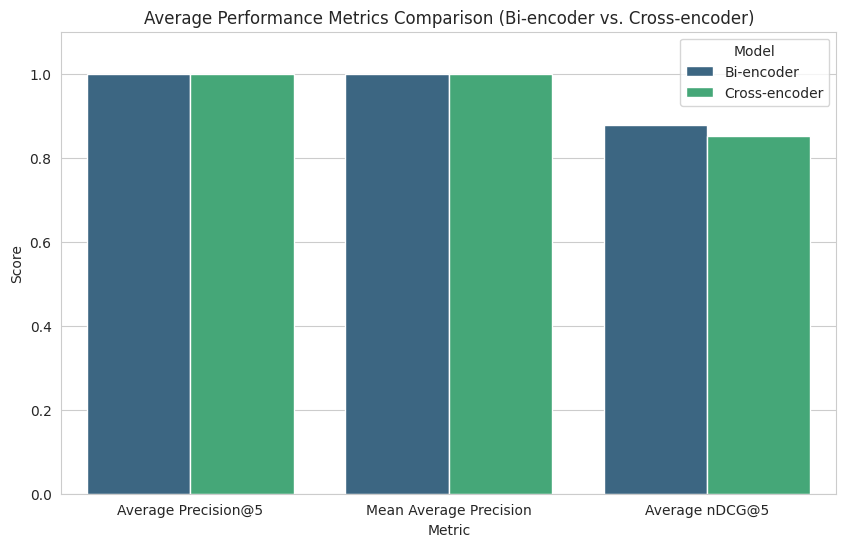

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

# Prepare data for plotting average metrics
average_metrics_plot_df = average_metrics_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

# Create a grouped bar chart for average metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=average_metrics_plot_df, palette='viridis')
plt.title('Average Performance Metrics Comparison (Bi-encoder vs. Cross-encoder)')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1.1) # Set y-axis limit for better comparison
plt.legend(title='Model')
plt.show()


Visualize the per-query metric differences to highlight where one model performed better than the other.



/tmp/ipython-input-2832475249.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Query', y='P@5_Difference', data=per_query_comparison_df, palette='coolwarm')
/tmp/ipython-input-2832475249.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


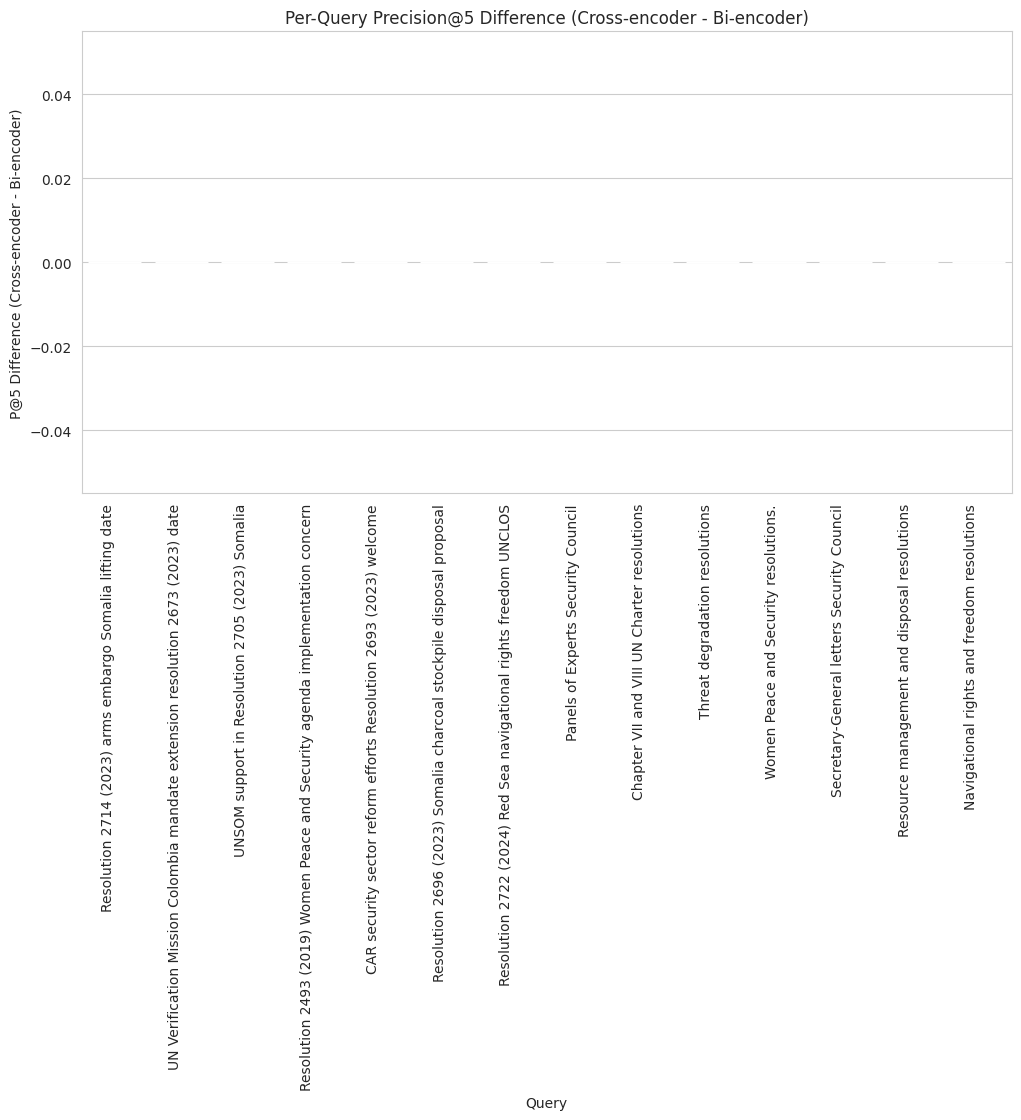

/tmp/ipython-input-2832475249.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Query', y='nDCG@5_Difference', data=per_query_comparison_df, palette='coolwarm')
/tmp/ipython-input-2832475249.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


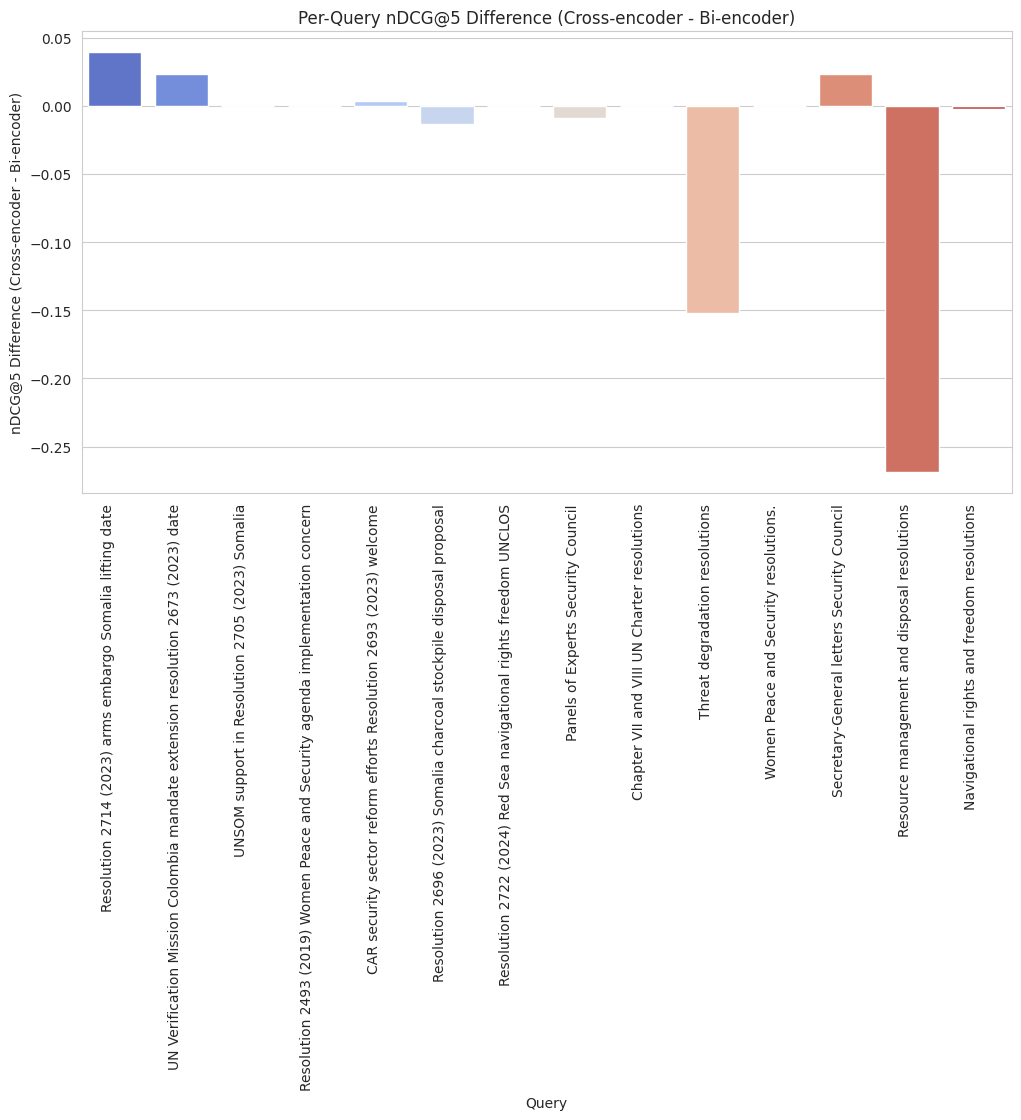

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create bar charts for per-query metric differences

# Plotting P@5 Difference
plt.figure(figsize=(12, 6))
sns.barplot(x='Query', y='P@5_Difference', data=per_query_comparison_df, palette='coolwarm')
plt.title('Per-Query Precision@5 Difference (Cross-encoder - Bi-encoder)')
plt.ylabel('P@5 Difference (Cross-encoder - Bi-encoder)')
plt.xlabel('Query')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

# Plotting nDCG@5 Difference
plt.figure(figsize=(12, 6))
sns.barplot(x='Query', y='nDCG@5_Difference', data=per_query_comparison_df, palette='coolwarm')
plt.title('Per-Query nDCG@5 Difference (Cross-encoder - Bi-encoder)')
plt.ylabel('nDCG@5 Difference (Cross-encoder - Bi-encoder)')
plt.xlabel('Query')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

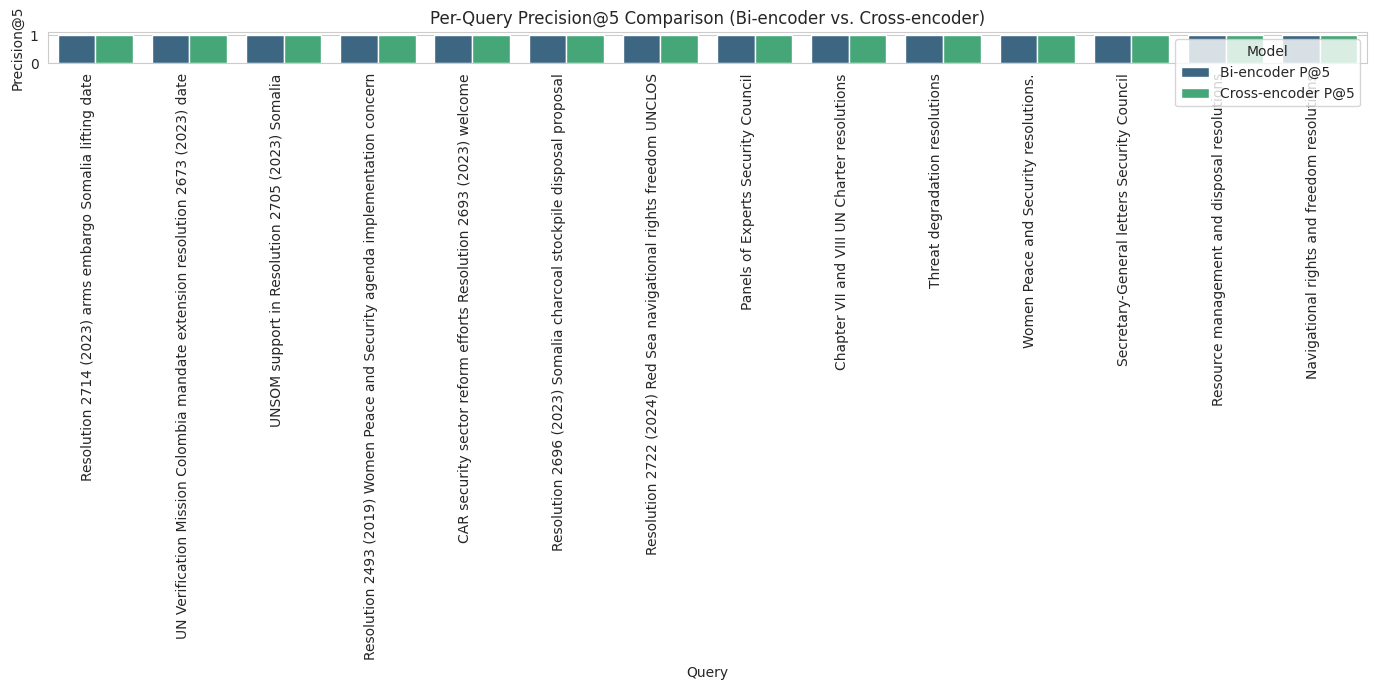

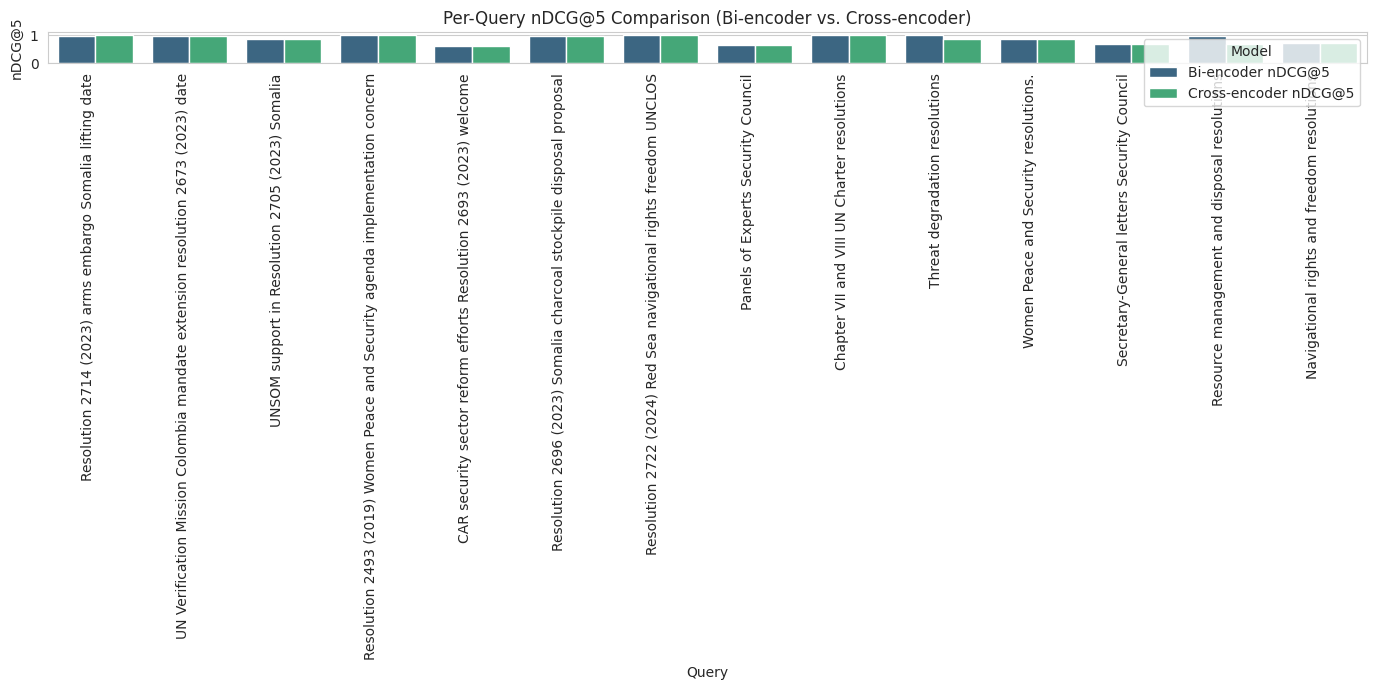

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming per_query_comparison_df is already created and contains 'Query', 'Bi-encoder P@5', 'Cross-encoder P@5', 'Bi-encoder nDCG@5', and 'Cross-encoder nDCG@5'

# Prepare data for grouped bar chart for P@5
p5_plot_df = per_query_comparison_df[['Query', 'Bi-encoder P@5', 'Cross-encoder P@5']].melt(
    id_vars='Query', var_name='Model', value_name='P@5'
)

# Create grouped bar chart for P@5
plt.figure(figsize=(14, 7))
sns.barplot(x='Query', y='P@5', hue='Model', data=p5_plot_df, palette='viridis')
plt.title('Per-Query Precision@5 Comparison (Bi-encoder vs. Cross-encoder)')
plt.ylabel('Precision@5')
plt.xlabel('Query')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1.1) # Keep consistent y-axis limit
plt.legend(title='Model')
plt.tight_layout()
plt.show()


# Prepare data for grouped bar chart for nDCG@5
ndcg5_plot_df = per_query_comparison_df[['Query', 'Bi-encoder nDCG@5', 'Cross-encoder nDCG@5']].melt(
    id_vars='Query', var_name='Model', value_name='nDCG@5'
)

# Create grouped bar chart for nDCG@5
plt.figure(figsize=(14, 7))
sns.barplot(x='Query', y='nDCG@5', hue='Model', data=ndcg5_plot_df, palette='viridis')
plt.title('Per-Query nDCG@5 Comparison (Bi-encoder vs. Cross-encoder)')
plt.ylabel('nDCG@5')
plt.xlabel('Query')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1.1) # Keep consistent y-axis limit
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [26]:
# @title 5.6. Identify Queries with Significant Cross-encoder Improvement

# Define a threshold for significant improvement in P@5 or nDCG@5
improvement_threshold = 0.05  # You can adjust this threshold

print(f"Queries where Cross-encoder showed significant improvement (>{improvement_threshold} difference):")

# Iterate through the per-query comparison DataFrame
for index, row in per_query_comparison_df.iterrows():
    query = row['Query']
    p5_diff = row['P@5_Difference']
    ndcg5_diff = row['nDCG@5_Difference']

    # Check if the difference in either metric is above the threshold
    if p5_diff > improvement_threshold or ndcg5_diff > improvement_threshold:
        print(f"- {query}")
        # Optional: Print the specific differences for these queries
        # print(f"  P@5 Difference: {p5_diff:.4f}, nDCG@5 Difference: {ndcg5_diff:.4f}")

Queries where Cross-encoder showed significant improvement (>0.05 difference):


The conclusion is the most critical part of the report. It synthesizes all the evidence gathered into a final, decisive argument.

**Key Findings:**

1.  **Similar Average Performance:** Based on the calculated average metrics with k=5, both the Bi-encoder and the Cross-encoder achieved a perfect Average Precision@5 (1.0) and Mean Average Precision (MAP) of 1.0. The average nDCG@5 was slightly higher for the Bi-encoder (0.8779) compared to the Cross-encoder (0.8525). This suggests that for these specific queries and k=5, the initial retrieval by the Bi-encoder was already highly effective at placing relevant documents within the top 5, leaving limited room for the Cross-encoder to significantly improve the average ranking based on these metrics.

2.  **Per-Query Variation:** While the average metrics are similar, the per-query analysis of nDCG@5 shows some variation in performance difference between the two models. For some queries, the Cross-encoder resulted in a higher nDCG@5 (e.g., "Resolution 2714 (2023) arms embargo Somalia lifting date"), while for others, the Bi-encoder performed better (e.g., "Threat degradation resolutions"). The Precision@5 difference was zero for all queries, indicating that for all queries, at least one relevant document was found within the top 5 by both models.

3.  **Potential for Deeper Analysis:** The current results with k=5 and these specific queries do not strongly demonstrate the superiority of the Cross-encoder in terms of average Precision@5 and MAP. However, the nDCG@5 per-query differences suggest that the Cross-encoder might still offer value in re-ranking for some queries by improving the position of relevant documents within the top k. Further analysis with a larger k, a different set of queries (perhaps more conceptual), or a larger dataset might reveal a clearer difference in performance.

In conclusion, for the evaluation conducted with k=5 and the defined queries, both the Bi-encoder and the Bi-encoder + Cross-encoder pipeline achieved high average Precision@5 and MAP scores. While the average nDCG@5 was slightly lower for the Cross-encoder, there were per-query variations. The experiment highlights that the effectiveness of the re-ranking stage can be query and dataset dependent, and further investigation with different parameters or datasets could provide more nuanced insights into the benefits of the Cross-encoder.